In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import load_img
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

2022-06-26 12:03:12.691409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-26 12:03:12.691433: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BASE_DIR = './input/utkface-new/UTKFace/'

image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    if len(temp) == 4:
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)

  0%|          | 0/16383 [00:00<?, ?it/s]

In [78]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race']= image_paths, age_labels, gender_labels, race_labels
df = df.sample(n=3000, random_state = 123)

In [79]:
def extract_features(images):
    features = []
    i=0
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((32, 32), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 1024)
    return features

In [80]:
X = extract_features(df['image'])

  0%|          | 0/3000 [00:00<?, ?it/s]

In [81]:
X = X/255.0
y_gender = np.array(df['gender'])

In [82]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier',SVC())])
kfold = StratifiedKFold(n_splits=5, random_state = 123, shuffle = True)

In [83]:
param_grid = {
    'classifier__gamma' : [0.0001 ,0.001, 1],
    'classifier__C': [1,10,100]
}
grid = GridSearchCV(pipe, param_grid,verbose = 4, cv=kfold, return_train_score = True)

In [84]:
grid.fit(X, y_gender)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier__C=1, classifier__gamma=0.0001;, score=(train=0.826, test=0.833) total time=   2.6s
[CV 2/5] END classifier__C=1, classifier__gamma=0.0001;, score=(train=0.833, test=0.807) total time=   2.5s
[CV 3/5] END classifier__C=1, classifier__gamma=0.0001;, score=(train=0.826, test=0.807) total time=   2.5s
[CV 4/5] END classifier__C=1, classifier__gamma=0.0001;, score=(train=0.822, test=0.823) total time=   2.6s
[CV 5/5] END classifier__C=1, classifier__gamma=0.0001;, score=(train=0.833, test=0.808) total time=   2.5s
[CV 1/5] END classifier__C=1, classifier__gamma=0.001;, score=(train=0.927, test=0.853) total time=   2.4s
[CV 2/5] END classifier__C=1, classifier__gamma=0.001;, score=(train=0.927, test=0.822) total time=   2.4s
[CV 3/5] END classifier__C=1, classifier__gamma=0.001;, score=(train=0.925, test=0.823) total time=   2.4s
[CV 4/5] END classifier__C=1, classifier__gamma=0.001;, score=(train=0.925, tes

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [1, 10, 100],
                         'classifier__gamma': [0.0001, 0.001, 1]},
             return_train_score=True, verbose=4)

In [85]:
grid.best_params_

{'classifier__C': 10, 'classifier__gamma': 0.0001}

In [86]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [87]:
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.876845,0.078982,0.653894,0.010198,1,0.0001,"{'classifier__C': 1, 'classifier__gamma': 0.0001}",0.833333,0.806667,0.806667,...,0.815667,0.010832,6,0.825833,0.832500,0.825833,0.821667,0.833333,0.827833,0.004428
1,1.736052,0.029082,0.692345,0.012454,1,0.001,"{'classifier__C': 1, 'classifier__gamma': 0.001}",0.853333,0.821667,0.823333,...,0.833667,0.011518,4,0.926667,0.926667,0.924583,0.925417,0.923333,0.925333,0.001275
2,2.674521,0.027545,0.981744,0.007919,1,1,"{'classifier__C': 1, 'classifier__gamma': 1}",0.508333,0.511667,0.510000,...,0.510667,0.001700,9,0.999583,0.999583,0.998750,0.998750,0.998750,0.999083,0.000408
3,1.359020,0.018690,0.489186,0.028537,10,0.0001,"{'classifier__C': 10, 'classifier__gamma': 0.0...",0.865000,0.836667,0.836667,...,0.849333,0.013021,1,0.899583,0.897500,0.896667,0.893750,0.893750,0.896250,0.002252
4,2.161496,0.021427,0.654910,0.006192,10,0.001,"{'classifier__C': 10, 'classifier__gamma': 0.001}",0.838333,0.840000,0.845000,...,0.839667,0.009393,2,0.997917,0.998333,0.996250,0.996667,0.997083,0.997250,0.000773
5,2.651853,0.001172,1.027628,0.050754,10,1,"{'classifier__C': 10, 'classifier__gamma': 1}",0.510000,0.511667,0.511667,...,0.511333,0.001247,7,0.999583,0.999583,0.998750,0.998750,0.998750,0.999083,0.000408
6,1.375356,0.011079,0.422906,0.024423,100,0.0001,"{'classifier__C': 100, 'classifier__gamma': 0....",0.828333,0.840000,0.818333,...,0.835000,0.020138,3,0.967500,0.961250,0.968333,0.961667,0.962083,0.964167,0.003084
7,2.188205,0.012032,0.652980,0.005100,100,0.001,"{'classifier__C': 100, 'classifier__gamma': 0....",0.838333,0.833333,0.825000,...,0.832000,0.008524,5,0.999583,0.999583,0.998750,0.998750,0.998750,0.999083,0.000408
8,2.655825,0.009634,1.028053,0.050860,100,1,"{'classifier__C': 100, 'classifier__gamma': 1}",0.510000,0.511667,0.511667,...,0.511333,0.001247,7,0.999583,0.999583,0.998750,0.998750,0.998750,0.999083,0.000408


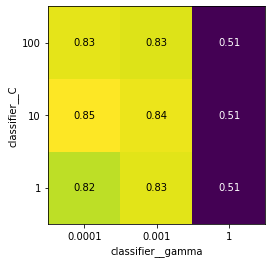

In [88]:
scores = np.array(results.mean_test_score).reshape(3,3,1)
scores = scores[:,:,0]
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

In [97]:
df2 = pd.DataFrame()
df2['image'],  df2['gender']= image_paths, gender_labels
df2 = df2.sample(n=3000, random_state = 777)

In [98]:
X2 = extract_features(df2['image'])

  0%|          | 0/3000 [00:00<?, ?it/s]

In [99]:
X2 = X2/255.0
y_gender = np.array(df2['gender'])

In [100]:
result = grid.predict(X2)

In [101]:
binary_conf_matrix = tf.math.confusion_matrix(result, y_gender)

In [102]:
binary_conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1188,  186],
       [ 239, 1387]], dtype=int32)>

In [103]:
result

array([0, 0, 0, ..., 1, 0, 1])

In [96]:
y_gender

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0])